### Kaggle Data Science BOWL 2017 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import scipy.ndimage as ndimage
from sklearn.cross_validation import KFold
from skimage import measure, morphology, segmentation
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import dicom
%matplotlib inline
p = sns.color_palette()
import time

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1


/home/mra/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### presets

In [2]:
path2data='../sample_images/'
#path2data='../stage1/'
path2data='/media/mra/My Passport/Kaggle/datascience2017/data/stage1/'
patients=os.listdir(path2data)
patients.sort()
print len(patients)

path2output='./output/data/'

# dispaly
display_ena=False

# resize
h,w=512,512

1595


### Functions

In [3]:
# get pixel spacing
def get_spacing(path):
    RefDs= dicom.read_file(path + '/' +os.listdir(path)[0])
    
    
    # Load spacing values (in mm)
    #ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]))
    
    return ConstPixelSpacing


# Load dicom files
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def array_stats(X):
    X=np.asarray(X)
    print 'array shape: ',X.shape, X.dtype
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print 'min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X))
    


### Get data stats

wait ...
array shape:  (1595,) int64
min: 94, max: 541, avg: 1.79e+02, std:67.0
Total patients 1595 Total DCM files 285380


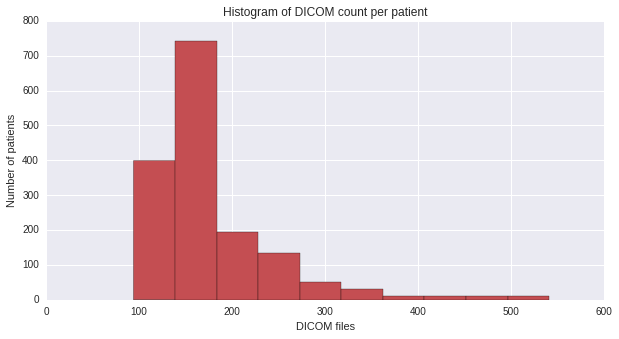

In [4]:
print 'wait ...'
nb_dicoms=[]
for d in patients:
    #print("Patient '{}' has {} scans".format(d, len(os.listdir(path2data + d))))
    nb_dicoms.append(len(os.listdir(path2data + d)))

array_stats(nb_dicoms)    
print('Total patients {} Total DCM files {}'.format(len(patients), len(glob.glob(path2data+'*/*.dcm'))))

plt.figure(figsize=((10,5)))
plt.hist(nb_dicoms, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('DICOM files')
plt.title('Histogram of DICOM count per patient')
plt.show()

### Training stats

In [5]:
df_train = pd.read_csv('../stage1_labels.csv')
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()


Number of training patients: 1397
Cancer rate: 25.91%


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


## sample patinet with cancer

In [10]:
path2spacing='/media/mra/win71/data/misc/kaggle/datascience2017/data/dsb_spacing.hdf5'
import h5py

ff=h5py.File(path2spacing,'w-')

for p_id in df_train.id:
    spcaing=get_spacing(path2data+p_id)
    print p_id,spcaing
    ff[p_id]=spcaing
ff.close()
print 'spacing saved!'

0015ceb851d7251b8f399e39779d1e7d (0.693359, 0.693359)
0030a160d58723ff36d73f41b170ec21 (0.582031, 0.582031)
003f41c78e6acfa92430a057ac0b306e (0.80859375, 0.80859375)
006b96310a37b36cccb2ab48d10b49a3 (0.665, 0.665)
008464bb8521d09a42985dd8add3d0d2 (0.722656, 0.722656)
0092c13f9e00a3717fdc940641f00015 (0.6640625, 0.6640625)
00986bebc45e12038ef0ce3e9962b51a (0.683594, 0.683594)
00cba091fa4ad62cc3200a657aeb957e (0.597656, 0.597656)
00edff4f51a893d80dae2d42a7f45ad1 (0.673828, 0.673828)
0121c2845f2b7df060945b072b2515d7 (0.6640625, 0.6640625)
013395589c01aa01f8df81d80fb0e2b8 (0.537109375, 0.537109375)
01de8323fa065a8963533c4a86f2f6c1 (0.662109, 0.662109)
01e349d34c06410e1da273add27be25c (0.6640625, 0.6640625)
01f1140c8e951e2a921b61c9a7e782c2 (0.703125, 0.703125)
024efb7a1e67dc820eb61cbdaa090166 (0.92578125, 0.92578125)
0257df465d9e4150adef13303433ff1e (0.64, 0.64)
0268f3a7a17412178cfb039e71799a80 (0.664062, 0.664062)
026be5d5e652b6a7488669d884ebe297 (0.585938, 0.585938)
02801e3bbcc6966cb115a9